# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.18 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
from maddpg_agent import Agent
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import random
import time
import torch

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [5]:
ADD_NOISE = True
SOLVED_SCORE = 0.5
RANGE_EPISODES = 100

# Multi-Agent Deep Deterministic Policy Gradient (MADDPG)
def maddpg(agent_1, agent_2, n_episodes=2000, max_t=1000, train_mode=True):
   
    scores_window = deque(maxlen=RANGE_EPISODES)
    scores_all = []
    moving_average = []
    best_score = -np.inf
    best_episode = 0
    already_solved = False
    start_time = time.time()

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]         # resetting environment
        states = np.reshape(env_info.vector_observations, (1,48)) # get and combine states 
        agent_1.reset()
        agent_2.reset()
        scores = np.zeros(num_agents)
        while True:
            action_1 = agent_1.act(states, ADD_NOISE)                        # choose action
            action_2 = agent_2.act(states, ADD_NOISE)                        
            actions = np.concatenate((action_1, action_2), axis=0).flatten() # choose and combine agents actions
            env_info = env.step(actions)[brain_name]           # send agents actions to the environment
            next_states = np.reshape(env_info.vector_observations, (1, 48)) # combine next states
            rewards = env_info.rewards                         # get reward
            done = env_info.local_done                         # see if episode done
            agent_1.step(states, actions, rewards[0], next_states, done, 0) # learn
            agent_2.step(states, actions, rewards[1], next_states, done, 1) 
            scores += np.max(rewards)                          # update the score of each agent
            states = next_states                               # change states to next time step
            if np.any(done):                                   # exit loop if episode done
                break
        if i_episode % 10 == 0:
            duration = time.time() - start_time
        ep_best_score = np.max(scores)
        scores_window.append(ep_best_score)
        scores_all.append(ep_best_score)
        moving_average.append(np.mean(scores_window))


        # save best score                        
        if ep_best_score > best_score:
            best_score = ep_best_score
            best_episode = i_episode
        
        # print results
        if i_episode % PRINT_10 == 0:
            print('Episodes {:0>4d} ({} sec)\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode, round(duration), np.max(scores_all[-10:]), moving_average[-1]))

        # check if environment is solved and keep best performing models
        if moving_average[-1] >= SOLVED_SCORE:
            if not already_solved:
                print('<-- Goal reached in {:d} episodes! \
                \n<-- Moving Average: {:.3f} over past {:d} episodes'.format(
                    i_episode-RANGE_EPISODES, moving_average[-1], RANGE_EPISODES))
                already_solved = True
                # save 
                torch.save(agent_1.actor_local.state_dict(), 'trained_models/checkpoint_actor_1.pth')
                torch.save(agent_1.critic_local.state_dict(), 'trained_models/checkpoint_critic_1.pth')
                torch.save(agent_2.actor_local.state_dict(), 'trained_models/checkpoint_actor_2.pth')
                torch.save(agent_2.critic_local.state_dict(), 'trained_models/checkpoint_critic_2.pth')
            elif ep_best_score >= best_score:
                print('<-- New best score!\
                \nEpisode {:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode, ep_best_score, moving_average[-1]))
                # save
                torch.save(agent_1.actor_local.state_dict(), 'trained_models/checkpoint_actor_1.pth')
                torch.save(agent_1.critic_local.state_dict(), 'trained_models/checkpoint_critic_1.pth')
                torch.save(agent_2.actor_local.state_dict(), 'trained_models/checkpoint_actor_2.pth')
                torch.save(agent_2.critic_local.state_dict(), 'trained_models/checkpoint_critic_2.pth')
            elif (i_episode-best_episode) >= 200:
                # stop the training if model stops converging
                print('<-- Training stopped. Best score not updated during last 200 episodes')
                break
            else:
                continue
        if i_episode % 10 == 0:
            start_time = time.time()
            
    return scores_all, moving_average


In [6]:
# initialize agents
agent_1 = Agent(state_size, action_size, num_agents=1, random_seed=1)
agent_2 = Agent(state_size, action_size, num_agents=1, random_seed=1)

Actor Local Network :
Actor(
  (fc1): Linear(in_features=48, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)
Actor Target Network :
Actor(
  (fc1): Linear(in_features=48, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)
Critic Local Network:
Critic(
  (fcs1): Linear(in_features=48, out_features=256, bias=True)
  (fc2): Linear(in_features=260, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)
Critic Target Network:
Critic(
  (fcs1): Linear(in_features=48, out_features=256, bias=True)
  (fc2): Linear(in_features=260, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)
Actor Local Network :
Actor(
  (fc1): Linear(in_features=48, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=12

In [7]:
scores, avgs = maddpg(agent_1=agent_1, agent_2=agent_2)

Episodes 0010 (3 sec)	Max Reward: 0.100	Moving Average: 0.020
Episodes 0020 (3 sec)	Max Reward: 0.000	Moving Average: 0.010
Episodes 0030 (3 sec)	Max Reward: 0.000	Moving Average: 0.007
Episodes 0040 (3 sec)	Max Reward: 0.000	Moving Average: 0.005
Episodes 0050 (3 sec)	Max Reward: 0.100	Moving Average: 0.006
Episodes 0060 (3 sec)	Max Reward: 0.000	Moving Average: 0.005
Episodes 0070 (3 sec)	Max Reward: 0.000	Moving Average: 0.004
Episodes 0080 (3 sec)	Max Reward: 0.000	Moving Average: 0.004
Episodes 0090 (3 sec)	Max Reward: 0.000	Moving Average: 0.003
Episodes 0100 (3 sec)	Max Reward: 0.000	Moving Average: 0.003
Episodes 0110 (3 sec)	Max Reward: 0.000	Moving Average: 0.001
Episodes 0120 (3 sec)	Max Reward: 0.000	Moving Average: 0.001
Episodes 0130 (3 sec)	Max Reward: 0.000	Moving Average: 0.001
Episodes 0140 (3 sec)	Max Reward: 0.000	Moving Average: 0.001
Episodes 0150 (3 sec)	Max Reward: 0.100	Moving Average: 0.001
Episodes 0160 (3 sec)	Max Reward: 0.000	Moving Average: 0.001
Episodes

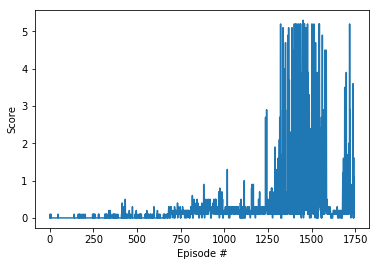

In [8]:
# plot scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
plt.savefig('Score plot')

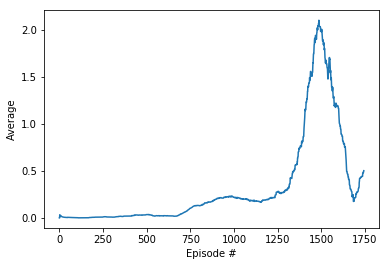

In [9]:
# plot moving averages
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(avgs)+1), avgs)
plt.ylabel('Average')
plt.xlabel('Episode #')
plt.show()
plt.savefig('Average plot')